In [1]:
epoch_idx = 1

In [2]:
import pandas as pd

episodes_data = pd.read_csv(f'episodes_data_epoch_{epoch_idx}.csv')
episodes_data.dropna(inplace=True)
episodes_data.reset_index(drop=True, inplace=True)

In [3]:
episodes_data

,episode_id,episode_name,episode_description,show_id,show_category
0,0347KaI75ADlF0HLYGKMhR,"Fashion Tier List (Supreme, Rick Owens, etc.)",Max Bratter and Allen Underwood rank some of t...,3ozYIoFrKrBkn6XzlaZZe8,Arts & Entertainment
1,4n9xXUvxepubHp9OuvFmX5,Is Ken Carson the true successor to Playboi Ca...,Max Bratter and Allen Underwood spend this epi...,3ozYIoFrKrBkn6XzlaZZe8,Arts & Entertainment
2,7LLAkFrGLPGM4hpwYOeGq3,A&E is For All the Dogs,Max Bratter and Allen Underwood dedicate this ...,3ozYIoFrKrBkn6XzlaZZe8,Arts & Entertainment
3,4uBmFBXNFQmo8eG5OqIwhD,Is Lil Tecca falling off? Which new songs and ...,In the first episode of The Spectator’s Arts &...,3ozYIoFrKrBkn6XzlaZZe8,Arts & Entertainment
4,4sopLohQdirkxwGoQuQm0T,Is Dax Shepard Bert's New Best Friend? | 2 Be...,Don’t forget to check out Dax Shepard’s own po...,1PgDUTgeyu3FOzK1FcBoqa,Arts & Entertainment
...,...,...,...,...,...
96753,79yguFEWTN58qNrgStGY7d,True Crime: Ep. 4: A Jonestown Sized Mess.,"Between 1955 and 1978, James Warren Jones was ...",4PIzwqv071QLpBHEEBWgQp,True Crime
96754,2RXcaS9PgrXt1n5qloPxo0,True Crime: Ep. 3: Ted Bundy And A Huge Pain I...,"Good morning, good day and welcome to the thir...",4PIzwqv071QLpBHEEBWgQp,True Crime
96755,5s6aGOk9x44IeuBNtKDkV0,"True Crime: Ep. 2 Amanda Knox, Murder and Misi...",Hey Folks! and welcome back to the True Crime ...,4PIzwqv071QLpBHEEBWgQp,True Crime
96756,1jiGcJ8bGtx3gqFZNaPiDM,True Crime: Ep. 1 Breonna Taylor And A Politic...,Breonna Taylor was twenty eight at the night o...,4PIzwqv071QLpBHEEBWgQp,True Crime


In [4]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words += ['show', 'shows', 'podcast', 'podcasts', 'episode', 'episodes']

def preprocess_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)
    tokens = word_tokenize(text.lower())
    meaningful_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    return meaningful_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zxr01\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zxr01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import numpy as np
from scipy.sparse import csr_matrix, save_npz

word_counts = []
all_words = []

for description in episodes_data['episode_description']:
    words = preprocess_text(description)
    word_counts.append(Counter(words))
    all_words.extend(words)

all_word_counts = Counter(all_words)
all_word_counts = {key: value for key, value in all_word_counts.items() if value > 10}
filtered_words = list(all_word_counts.keys())

In [6]:
with open("filtered_words.txt", "w") as f:
    for word in filtered_words:
        f.write(f"{word}\n")

In [77]:
#word_counts = pd.DataFrame(word_counts, dtype=pd.SparseDtype(int))[all_word_counts.keys()].replace(np.nan, 0)

rows = []
cols = []
data = []

for i, word_count in enumerate(word_counts):
    for word, count in word_count.items():
        if word in filtered_words:
            rows.append(i)
            cols.append(filtered_words.index(word))
            data.append(count)

sparse_matrix = csr_matrix((data, (rows, cols)), shape=(len(word_counts), len(filtered_words)))
save_npz(f'sparse_matrix_{epoch_idx}.npz', sparse_matrix)

from scipy.sparse import csr_matrix, load_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import johnson_lindenstrauss_min_dim

sparse_matrix = load_npz(f'sparse_matrix_{epoch_idx}.npz')

target_dim = johnson_lindenstrauss_min_dim(sparse_matrix.shape[0], eps=0.1)

svd = TruncatedSVD(n_components=target_dim)

principal_components = svd.fit_transform(sparse_matrix)

In [83]:
import joblib

joblib.dump(svd, 'pca_model.pkl')

['pca_model.pkl']

import joblib

loaded_svd = joblib.load('pca_model.pkl')

In [89]:
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("方差贡献率：", explained_variance_ratio)
print("累积方差贡献率：", cumulative_variance_ratio)

方差贡献率： [2.74247672e-02 2.20144546e-02 1.63010292e-02 ... 6.03694815e-06
 6.02754905e-06 6.02539240e-06]
累积方差贡献率： [0.02742477 0.04943922 0.06574025 ... 0.96029991 0.96030594 0.96031196]


In [145]:
print(sum(cumulative_variance_ratio <= 0.1))

6


In [146]:
print(sum(cumulative_variance_ratio <= 0.2))

32


In [156]:
print(sum(cumulative_variance_ratio <= 0.3))

87


In [148]:
print(sum(cumulative_variance_ratio <= 0.4))

187


In [149]:
print(sum(cumulative_variance_ratio <= 0.5))

361


In [150]:
print(sum(cumulative_variance_ratio <= 0.6))

661


In [105]:
loadings = pd.DataFrame(svd.components_.T, index=filtered_words, columns=[f'PC{i+1}' for i in range(svd.components_.shape[0])])

In [153]:
loadings['PC1'].abs().nlargest(20)

get          0.327208
us           0.266232
visit        0.193027
free         0.183836
new          0.158332
code         0.148159
learn        0.144890
first        0.143841
today        0.126830
like         0.123727
use          0.121695
instagram    0.111894
one          0.109102
follow       0.107170
also         0.101043
time         0.100774
sleep        0.099420
go           0.096010
support      0.094661
join         0.094098
Name: PC1, dtype: float64

In [130]:
loadings['PC2'].abs().nlargest(10)

sleep       0.583360
noise       0.478691
sounds      0.349535
white       0.261127
sound       0.229283
machine     0.158329
pink        0.095724
get         0.088353
deep        0.087667
relaxing    0.075032
Name: PC2, dtype: float64

In [136]:
loadings['PC3'].abs().nlargest(10)

unit      0.552973
size      0.508491
sizes     0.487783
px        0.420367
deg       0.054376
true      0.040738
top       0.040333
right     0.040277
left      0.040050
bottom    0.039905
Name: PC3, dtype: float64

In [137]:
loadings['PC4'].abs().nlargest(20)

visit        0.285423
get          0.213897
code         0.201419
us           0.200953
first        0.185626
bonus        0.132338
life         0.125455
free         0.123793
bets         0.116955
like         0.116926
use          0.107442
terms        0.107315
locked       0.105505
gametime     0.102890
app          0.101450
apply        0.101172
health       0.098798
instagram    0.098266
ks           0.094813
design       0.094329
Name: PC4, dtype: float64

In [138]:
loadings['PC5'].abs().nlargest(20)

us          0.360134
get         0.340876
visit       0.294238
learn       0.217300
ad          0.200990
choices     0.200788
follow      0.193297
code        0.181017
free        0.157768
use         0.144858
health      0.141350
de          0.129855
week        0.107670
twitter     0.106218
youtube     0.092746
en          0.092081
business    0.085056
go          0.081966
football    0.078526
life        0.078141
Name: PC5, dtype: float64

principal_components.shape # (96758, 9839)

In [164]:
principal_components[:,:87].shape

(96758, 87)

In [165]:
np.save(f'principal_components_{epoch_idx}.npy', principal_components[:,:87])

import numpy as np

loaded_principal_components = np.load(f'principal_components_{epoch_idx}.npy')

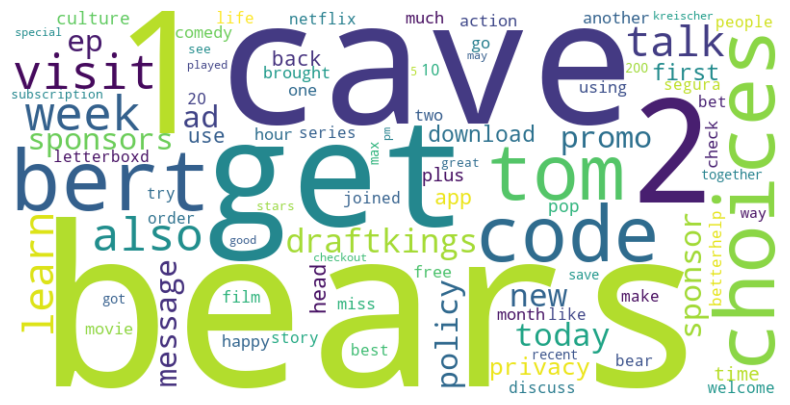

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
len(all_word_counts)

34223

In [6]:
[key for key, value in all_word_counts.items() if value >= 30000]

['get', 'visit', 'learn', 'new', 'us']

In [7]:
len([key for key, value in all_word_counts.items() if value <= 10])

0